In [2]:
import torch
import matplotlib.pyplot as plt
from typing import List, Sequence

# Answer 1

In [3]:
def sample_from_distribution(dist: List[float]) -> int:
    u = torch.rand([1])[0]
    
    if not (torch.tensor(dist) >= 0).all():
        raise Exception("Invalid distribution: all probabilities must be non-negative")

    if not (torch.tensor(dist).sum() == 1):
        raise Exception("Invalid distribution: measure must be 1")

    acc = 0
    for i, v in enumerate(dist):
        if u <= acc + v:
            return i

        acc += v

    assert False, "Unreachable"

def my_sampler(size: Sequence[int], dist: List[float], requires_grad: bool = False) -> torch.Tensor:
    tensor = torch.empty(size).apply_(lambda _: sample_from_distribution(dist))
    tensor.requires_grad = requires_grad
    return tensor

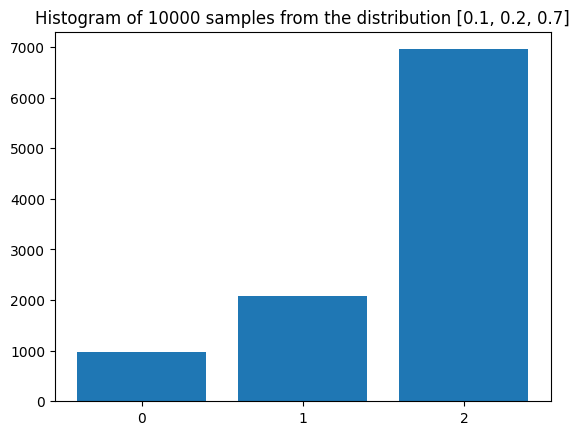

In [11]:
def sample_and_plot_histogram(n: int, dist: List[float]):
    m = len(dist)
    tensor = my_sampler((n, ), dist)
    plt.figure()
    plt.bar(x=range(m), height=tensor.histc(m))
    plt.title(f"Histogram of {n} samples from the distribution {dist}")
    plt.xticks(range(m))
    
    plt.show()

sample_and_plot_histogram(10_000, [0.1, 0.2, 0.7])